In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
import pandas as pd

In [2]:
img_folder=r'archive(2)/food-101/food-101/images'
img_data_array=[]
class_name=[]
IMG_WIDTH=200
IMG_HEIGHT=200
for dir1 in os.listdir(img_folder):
    if dir1 != ".DS_Store":
            class_name.append(dir1)

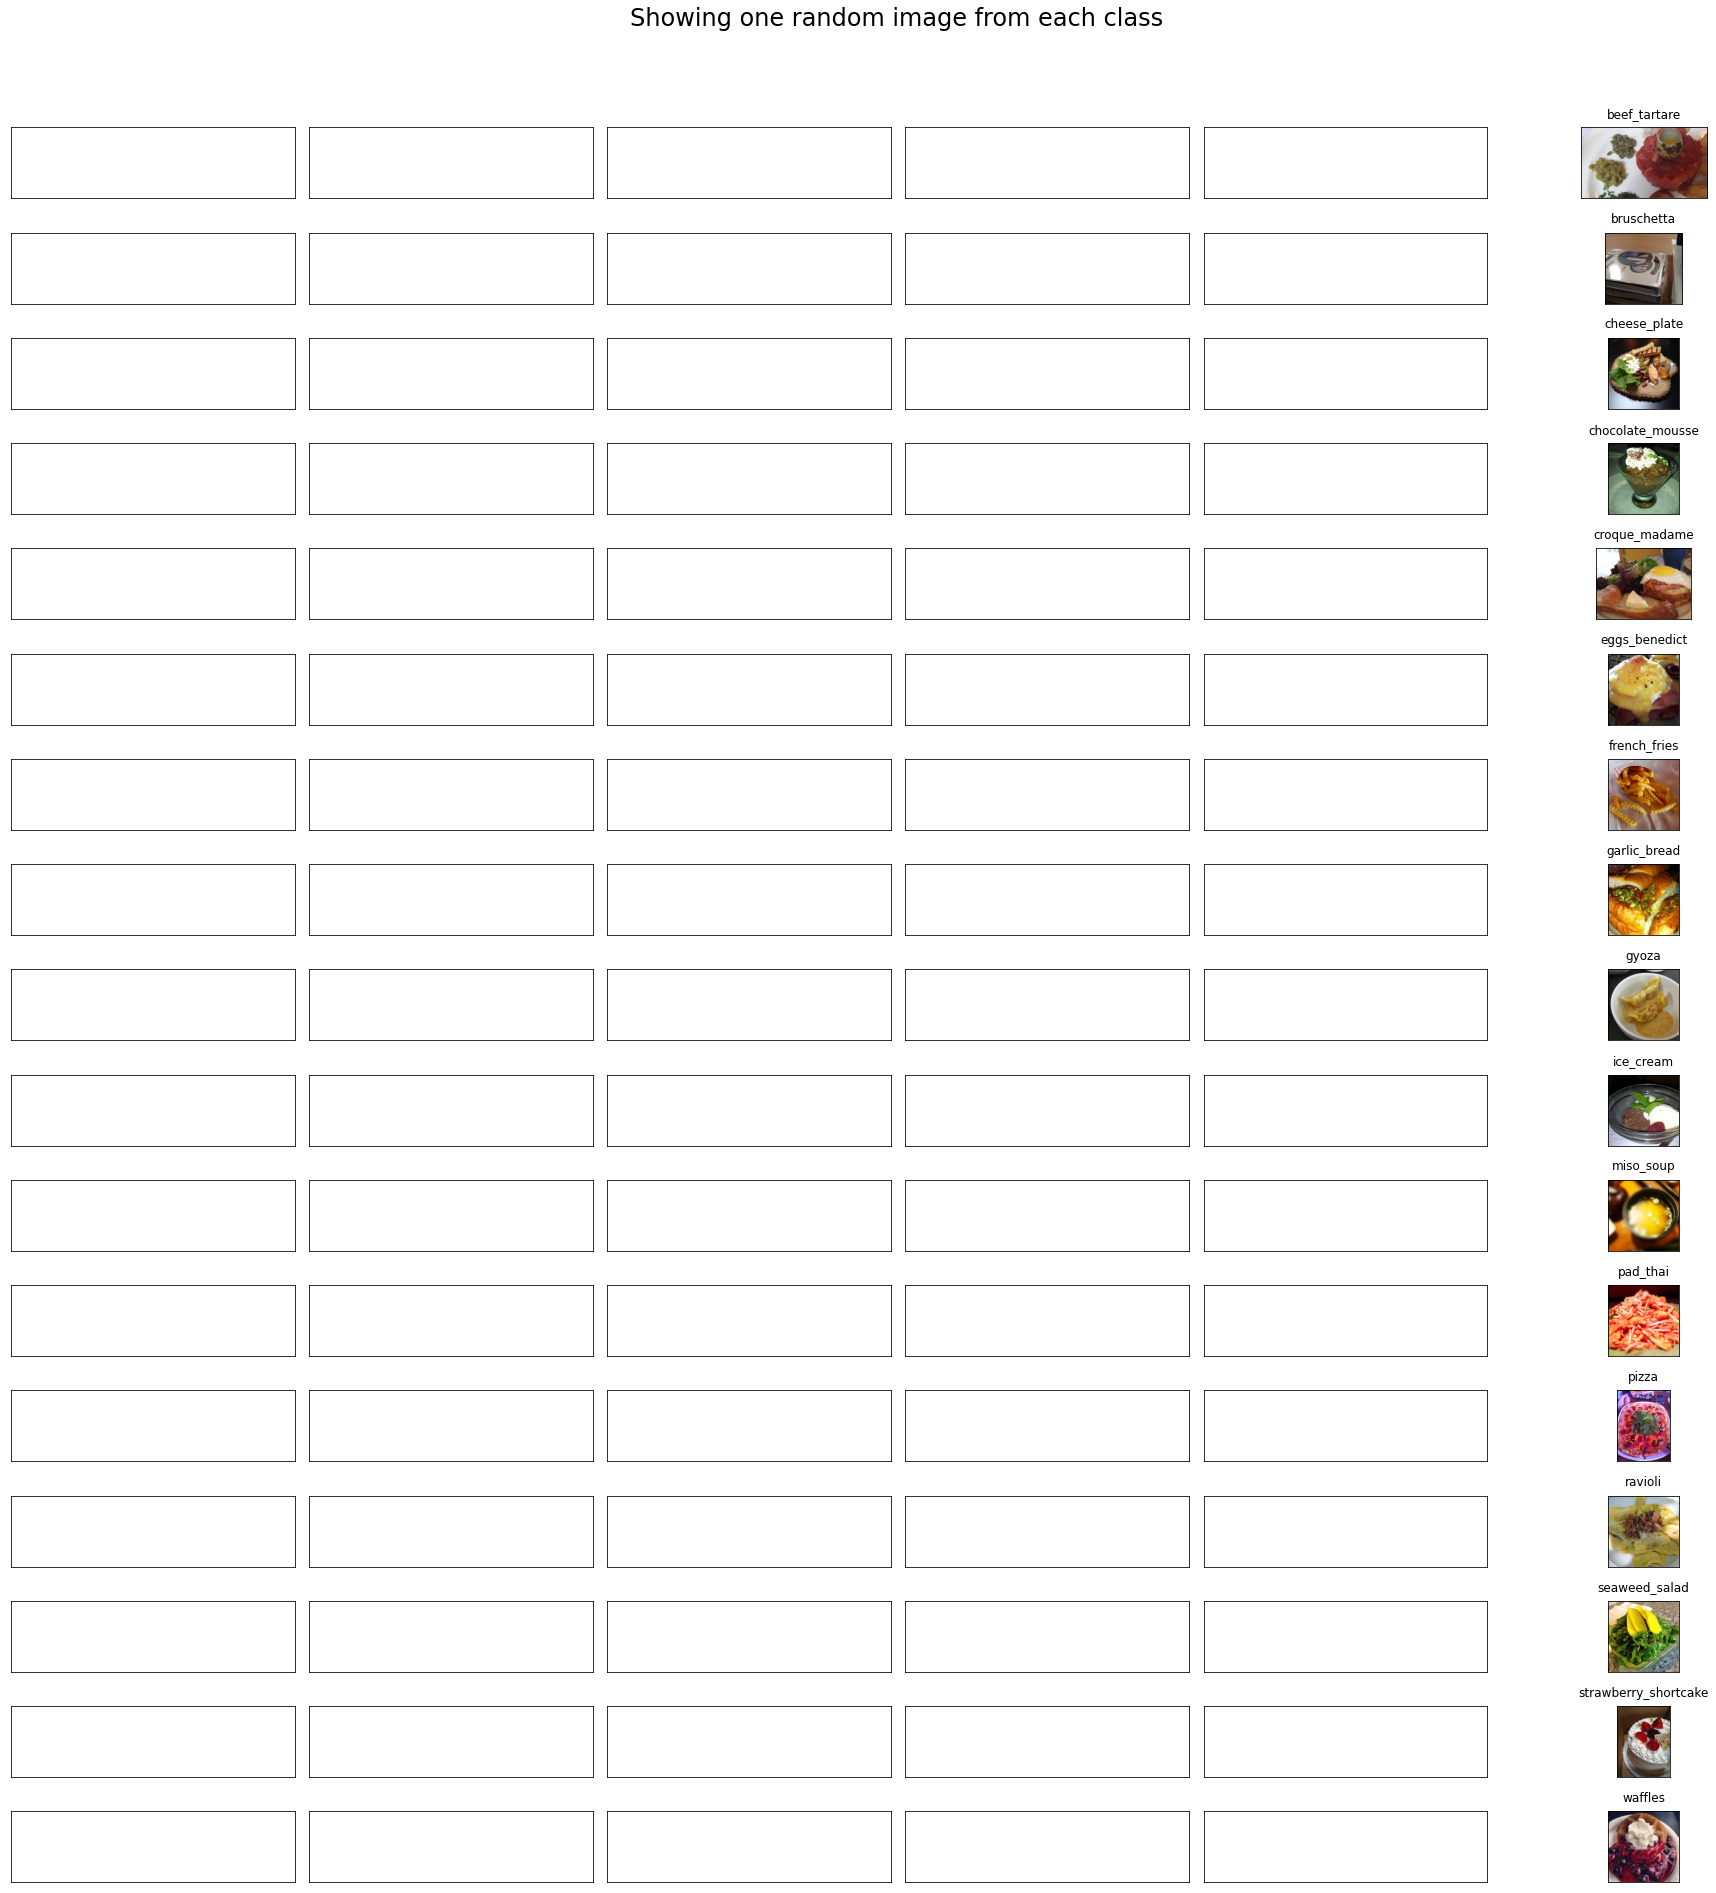

In [3]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue

foods_sorted = sorted(os.listdir(img_folder))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id] 
            food_id += 1
        except:
              break
    if food_selected == '.DS_Store':
        continue
        
    food_selected_images = os.listdir(os.path.join(img_folder,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(img_folder,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [4]:
image_folder = r'archive(2)/food-101/food-101/images'
meta_path = r'archive(2)/food-101/food-101/meta'

In [5]:
with open(r"archive(2)/food-101/food-101/meta/train.txt") as f:
    trains = f.read()
with open(r"archive(2)/food-101/food-101/meta/test.txt") as f:
    tests = f.read()

In [6]:
trains = trains.split("\n")
tests = tests.split("\n")

In [7]:
fish_and_chips_train = [i for i in trains if i.startswith("fish_and_chips")]
fish_and_chips_test = [i for i in tests if i.startswith("fish_and_chips")]
sushi_train = [i for i in trains if i.startswith("sushi")]
sushi_test = [i for i in tests if i.startswith("sushi")]
churros_train = [i for i in trains if i.startswith("churros")]
churros_test = [i for i in tests if i.startswith("churros")]
donuts_train = [i for i in trains if i.startswith("donuts")]
donuts_test = [i for i in tests if i.startswith("donuts")]
paella_train = [i for i in trains if i.startswith("paella")]
paella_test = [i for i in tests if i.startswith("paella")]

In [8]:
trains = fish_and_chips_train + sushi_train + churros_train + donuts_train + paella_train
tests = fish_and_chips_test + sushi_test + churros_test + donuts_test + paella_test

In [9]:
trains = [i + ".jpg" for i in trains]
tests = [i + ".jpg" for i in tests]


In [10]:
classes = ["fish_and_chips", "sushi", "churros", "donuts", "paella"]


In [11]:
def add_label (lista):
    training_data = []
    for cat in classes:
        for file in lista:
            if file.startswith(cat):
                training_data.append([file, cat])
    return training_data

trains = add_label(trains)
tests = add_label(tests)

In [12]:
df_train = pd.DataFrame(trains, columns = ["id", "label"])
df_test = pd.DataFrame(tests, columns = ["id", "label"])

In [13]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255)


In [14]:
train_generator=train_datagen.flow_from_dataframe(
                dataframe=df_train,
                directory=image_folder,
                x_col="id",
                y_col="label",
                subset="training",
                batch_size=16,
                seed=42,
                shuffle=True,
                class_mode="categorical",
                target_size=(299,299))

Found 3750 validated image filenames belonging to 5 classes.


In [15]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
                dataframe=df_test,
                directory=image_folder,
                x_col="id",
                y_col="label",
                batch_size=16,
                seed=42,
                shuffle=False,
                class_mode="categorical",
                target_size=(299,299))

Found 1250 validated image filenames belonging to 5 classes.


In [19]:
K.clear_session()
#img_width, img_height = 299, 299
batch_size = 16
nb_train_samples = 3750 
nb_validation_samples = 1250


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(5,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
#checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
#csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=test_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1)#,
                    #callbacks=[csv_logger, checkpointer])

Epoch 1/30
234/234 [==============================] - 2326s 10s/step - loss: 1.4709 - accuracy: 0.4397 - val_loss: 1.0625 - val_accuracy: 0.7885
Epoch 2/30
234/234 [==============================] - 2296s 10s/step - loss: 0.9716 - accuracy: 0.7394 - val_loss: 0.6236 - val_accuracy: 0.8862
Epoch 3/30
234/234 [==============================] - 5047s 22s/step - loss: 0.6746 - accuracy: 0.8211 - val_loss: 0.4260 - val_accuracy: 0.9175
Epoch 4/30
234/234 [==============================] - 11701s 50s/step - loss: 0.5297 - accuracy: 0.8546 - val_loss: 0.3317 - val_accuracy: 0.9311
Epoch 5/30
234/234 [==============================] - 2095s 9s/step - loss: 0.4620 - accuracy: 0.8693 - val_loss: 0.2784 - val_accuracy: 0.9439
Epoch 6/30
234/234 [==============================] - 2138s 9s/step - loss: 0.4096 - accuracy: 0.8881 - val_loss: 0.2488 - val_accuracy: 0.9463
Epoch 7/30
234/234 [==============================] - 2727s 12s/step - loss: 0.3810 - accuracy: 0.8894 - val_loss: 0.2267 - val_acc

In [20]:
model.save('model.hdf5')

In [21]:
model.save('model.h5')

In [25]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


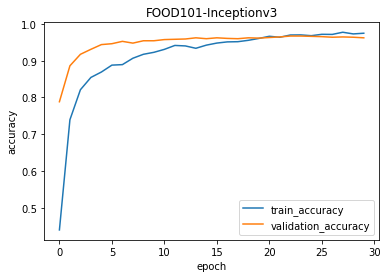

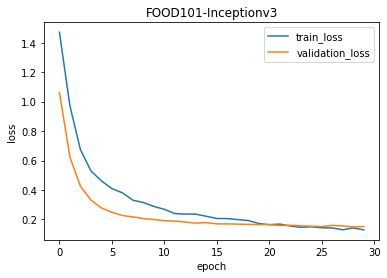

In [26]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [72]:
img = "static/sushi.jpg"

In [73]:
img = image.load_img(img, target_size=(299, 299))
img = image.img_to_array(img)                    
img = np.expand_dims(img, axis=0)         
img /= 255.
    

In [74]:
pred = model.predict(img)

In [75]:
pred[0]

array([6.8419635e-05, 2.1054891e-05, 2.7116921e-05, 9.5947453e-06,
       9.9987376e-01], dtype=float32)

In [76]:
index = np.argmax(pred)

In [77]:
index

4

In [79]:
class_map_5 = train_generator.class_indices
class_map_5

{'churros': 0, 'donuts': 1, 'fish_and_chips': 2, 'paella': 3, 'sushi': 4}